In [2]:
import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention

from utils import RMSE, rmse, mse, mae, save_train_val_losses

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [3]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

epochs = 10000
lr = 1e-4
batch = 64
sub = True # True
embedding_dim = 1024 # 1024
window_size = 6 # 12

### train/val

Transformer	 Epoch [1/10000], Train Loss: 4.674466, Val Loss: 4.605999
Transformer	 Epoch [2/10000], Train Loss: 4.110735, Val Loss: 4.142936
Transformer	 Epoch [3/10000], Train Loss: 3.989852, Val Loss: 4.049670
Transformer	 Epoch [4/10000], Train Loss: 3.955190, Val Loss: 4.036336
Transformer	 Epoch [5/10000], Train Loss: 3.943029, Val Loss: 4.039034
Transformer	 Epoch [6/10000], Train Loss: 3.932531, Val Loss: 4.038503
Transformer	 Epoch [7/10000], Train Loss: 3.918950, Val Loss: 4.023873
Transformer	 Epoch [8/10000], Train Loss: 3.913451, Val Loss: 4.031286
Transformer	 Epoch [9/10000], Train Loss: 3.908846, Val Loss: 4.033645
Transformer	 Epoch [10/10000], Train Loss: 3.894617, Val Loss: 4.026731 
Early Stop Triggered!
Min Train Loss: 3.894617406596206
Min Val Loss: 4.023873405857354
Attention	 Epoch [1/10000], Train Loss: 6.575953, Val Loss: 6.890311
Attention	 Epoch [2/10000], Train Loss: 5.153767, Val Loss: 5.614050
Attention	 Epoch [3/10000], Train Loss: 4.283476, Val Loss: 5.

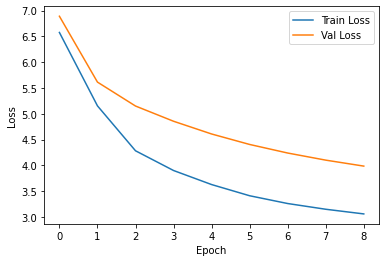

In [4]:
# result_df = pd.DataFrame(columns=['lr','batch','sub','embedding_dim','window_size','val_loss'])

### embedding
dataset = Embedding_Dataset(table_1, table_2, table_3, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

embedding_model = Embedding(128, 256, 512, embedding_dim, 512, 256, 128).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=lr)

embedding_train_losses = []
embedding_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
embedding_best_val_loss = float('inf')
embedding_best_model_weights = None

for epoch in range(epochs):
    embedding_model.train()
    embedding_total_train_loss = 0
    for data in train_dataloader:
        input = data[0].to(DEVICE)
        target = data[1].to(DEVICE)
        output = embedding_model(input).to(DEVICE)

        embedding_train_loss = criterion(output, target)
        embedding_total_train_loss += embedding_train_loss.item()

        optimizer.zero_grad()
        embedding_train_loss.backward()
        optimizer.step()

    embedding_avg_train_loss = embedding_total_train_loss / len(train_dataloader)
    embedding_train_losses.append(embedding_avg_train_loss)

    embedding_model.eval()
    embedding_total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = embedding_model(input).to(DEVICE)

            embedding_val_loss = criterion(output, target)
            embedding_total_val_loss += embedding_val_loss.item()

    embedding_avg_val_loss = embedding_total_val_loss / len(val_dataloader)
    embedding_val_losses.append(embedding_avg_val_loss)

    if  embedding_best_val_loss > embedding_avg_val_loss:
        embedding_best_val_loss = embedding_avg_val_loss
        embedding_best_model_weights = copy.deepcopy(embedding_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= max_early_stop_count:
        print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f} \nEarly Stop Triggered!')
        embedding_model.load_state_dict(embedding_best_model_weights)
        torch.save(embedding_model, f'../데이터/Checkpoint/embedding/embedding_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Val Loss: {embedding_avg_val_loss:.6f}')
    
save_train_val_losses(embedding_train_losses, embedding_val_losses, f'../데이터/Checkpoint/embedding/embedding_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

### transformer
# embedding_model = 'None'
# embedding_dim = 'None'
dataset = Apartment_Complex_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, 'DL', DEVICE)
# embedding_dim = 12
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_model = Transformer(embedding_dim, 1, 2, 2).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

transformer_train_losses = []
transformer_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
transformer_best_val_loss = float('inf')
transformer_best_model_weights = None

for epoch in range(epochs):
    transformer_model.train()
    transformer_total_train_loss = 0
    transformer_total_train_num = 1e-9
    for data in train_dataloader:
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if (trg[0] != 0):
            transformer_total_train_num += 1

            src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output = transformer_model(src, src_mask)

            transformer_train_loss = criterion(output[0], trg)
            transformer_total_train_loss += transformer_train_loss.item()

            optimizer.zero_grad()
            transformer_train_loss.backward()
            optimizer.step()
            
    transformer_avg_train_loss = transformer_total_train_loss / transformer_total_train_num
    transformer_train_losses.append(transformer_avg_train_loss)

    transformer_model.eval()
    transformer_total_val_loss = 0
    transformer_total_val_num = 1e-9
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if (trg[0] != 0):
                transformer_total_val_num += 1

                src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                output = transformer_model(src, src_mask)

                transformer_val_loss = criterion(output[0], trg)
                transformer_total_val_loss += transformer_val_loss.item()

    transformer_avg_val_loss = transformer_total_val_loss / transformer_total_val_num
    transformer_val_losses.append(transformer_avg_val_loss)

    if  transformer_best_val_loss > transformer_avg_val_loss:
        transformer_best_val_loss = transformer_avg_val_loss
        transformer_best_model_weights = copy.deepcopy(transformer_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1
        
    if early_stop_count >= max_early_stop_count:
        print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f} \nEarly Stop Triggered!')
        transformer_model.load_state_dict(transformer_best_model_weights)
        torch.save(transformer_model, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Val Loss: {transformer_avg_val_loss:.6f}')

save_train_val_losses(transformer_train_losses, transformer_val_losses, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

# embedding_dim = 'None'
### transformer attention
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
# embedding_dim = 12
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
val_indices = range(train_size, train_size + val_size)
# test_size = int(test_ratio * dataset_length)
# test_indices = range(train_size + val_size, dataset_length)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_att_model = TransformerAttention(transformer_model, embedding_dim, 1, DEVICE).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(transformer_att_model.parameters(), lr=lr)

transformer_att_train_losses = []
transformer_att_val_losses = []

max_early_stop_count = 3
early_stop_count = 0
transformer_att_best_val_loss = float('inf')
transformer_att_best_model_weights = None

for epoch in range(epoch):
    transformer_att_model.train()
    transformer_att_total_train_loss = 0
    transformer_att_total_train_num = 1e-9
    for data in train_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        try:
            anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
        except:
            continue
        trg = data[3][0].to(DEVICE)
        
        transformer_att_total_train_num += len(anw)

        for index in anw:
            output = transformer_att_model(src, index, max_len)
            
            transformer_att_train_loss = criterion(output, trg[index])
            transformer_att_total_train_loss += transformer_att_train_loss.item()
            
            optimizer.zero_grad()
            transformer_att_train_loss.backward()
            optimizer.step() 
            
    transformer_att_avg_train_loss = transformer_att_total_train_loss / transformer_att_total_train_num
    transformer_att_train_losses.append(transformer_att_avg_train_loss)

    transformer_att_model.eval()
    transformer_att_total_val_loss = 0
    transformer_att_total_val_num = 1e-9
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0][0].to(DEVICE)
            max_len = data[1][0].to(DEVICE)
            try:
                anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
            except:
                continue
            trg = data[3][0].to(DEVICE)
            
            transformer_att_total_val_num += len(anw)

            for index in anw:
                output = transformer_att_model(src, index, max_len)

                transformer_att_val_loss = criterion(output, trg[index])
                transformer_att_total_val_loss += transformer_att_val_loss.item()
                
    transformer_att_avg_val_loss = transformer_att_total_val_loss / transformer_att_total_val_num
    transformer_att_val_losses.append(transformer_att_avg_val_loss)
            
    if  transformer_att_best_val_loss > transformer_att_avg_val_loss:
        transformer_att_best_val_loss = transformer_att_avg_val_loss
        transformer_att_best_model_weights = copy.deepcopy(transformer_att_model.state_dict())
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= max_early_stop_count:
        print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f} \nEarly Stop Triggered!')
        transformer_att_model.load_state_dict(transformer_att_best_model_weights)
        torch.save(transformer_att_model, f'../데이터/Checkpoint/transformer/attention/attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
        break

    print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Val Loss: {transformer_att_avg_val_loss:.6f}')

save_train_val_losses(transformer_att_train_losses, transformer_att_val_losses, f'../데이터/Checkpoint/attention/transformer/attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

# result_df = result_df.append({
#     'lr': lr,
#     'batch': batch,
#     'sub': sub,
#     'embedding_dim': embedding_dim,
#     'window_size': window_size,
#     'val_loss': min(transformer_att_val_losses),
# }, ignore_index=True)

# result_df = result_df.sort_values('val_loss')
# result_df.to_excel(f'../데이터/Checkpoint/result/result_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}.xlsx')

In [5]:
torch.save(transformer_att_model, f'../데이터/Checkpoint/attention/attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')

### test

In [15]:
### transformer attention
embedding_model = torch.load("../데이터/Checkpoint/embedding/ws_18/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_18_epochs_13.pth", map_location=DEVICE)
transformer_att_model = torch.load("../데이터/Checkpoint/transformer/attention/ws_18/transformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_18_epochs_9.pth", map_location=DEVICE)
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

transformer_att_model.eval()
transformer_att_test_rmses = []
transformer_att_test_mses = []
transformer_att_test_maes = []

transformer_att_test_outputs = []
transformer_att_test_trgs = []

with torch.no_grad():
    for data in test_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        try:
            anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
        except:
            continue
        trg = data[3][0].to(DEVICE)

        for index in anw:
            output = transformer_att_model(src, index, max_len)
            
            transformer_att_test_outputs.append(output)
            transformer_att_test_trgs.append(trg[index])

save_path = f'../데이터/Checkpoint/transformer/attention/ws_18/transformer_attention_lr_{lr}_batch_{batch}_sub_{sub}_emb_{embedding_dim}_ws_{window_size}_epochs_{9}'
with open(f'{save_path}_test_rmses.txt', 'w') as f:
    for item in transformer_att_test_rmses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_mses.txt', 'w') as f:
    for item in transformer_att_test_mses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_maes.txt', 'w') as f:
    for item in transformer_att_test_maes:
        f.write("%s\n" % item)

transformer_att_test_outputs = torch.FloatTensor(transformer_att_test_outputs)
transformer_att_test_trgs = torch.FloatTensor(transformer_att_test_trgs) 

transformer_att_test_rmse = rmse(transformer_att_test_outputs, transformer_att_test_trgs)
transformer_att_test_mse = mse(transformer_att_test_outputs, transformer_att_test_trgs)
transformer_att_test_mae = mae(transformer_att_test_outputs, transformer_att_test_trgs)
        
print(f'Test RMSE: {transformer_att_test_rmse:.4f}')
print(f'Test MSE: {transformer_att_test_mse:.4f}')
print(f'Test MAE: {transformer_att_test_mae:.4f}')

Test RMSE: 2.1812
Test MSE: 4.7578
Test MAE: 1.7245


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:367: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:372: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
C:\Users\USER\AppData\Local\Temp\ipykernel_27336\1601207231.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k'

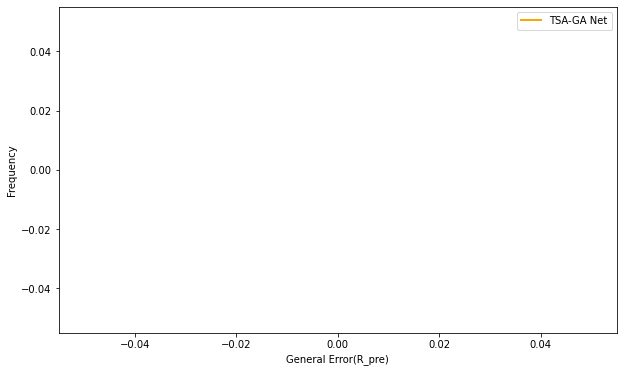

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(transformer_att_test_rmses, bins=30, density=True, color='white', alpha=0.5)

mu, std = norm.fit(transformer_att_test_rmses)
xmin, xmax = plt.xlim()
x = np.linspace(0, 10)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, color='orange')
plt.fill_between(x, p, color='orange', alpha=0.5)

plt.axvline(mu, color='k', linestyle='dashed', linewidth=1)
plt.text(mu + 0.1, max(p) + 0.05, 'mean = {:.2f}'.format(mu), color='k')

plt.legend(['TSA-GA Net'], loc='upper right')
plt.xlabel('General Error(R_pre)')
plt.ylabel('Frequency')
plt.show()

### 코로나

In [6]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class District_Dataset(Dataset):
    def __init__(self, model, table_1, table_2, table_3, embedding_dim, window_size, SUB, DEVICE):
        # 데이터프레임 복사본 생성
        table_1_copy = table_1.copy()
        table_2_copy = table_2.copy()
        table_3_copy = table_3.copy()

        # 정규화
        scaler = StandardScaler()
        table_1_copy[[cols for cols in table_1_copy.columns if cols not in ['aid','location','name']]] = scaler.fit_transform(table_1_copy[[cols for cols in table_1_copy.columns if cols not in ['aid','location','name']]])
        scaler.fit(table_2_copy[[cols for cols in table_2_copy.columns if cols not in ['did','year','month']]][:135])
        table_2_copy[[cols for cols in table_2_copy.columns if cols not in ['did','year','month']]] = scaler.transform(table_2_copy[[cols for cols in table_2_copy.columns if cols not in ['did','year','month']]])
        table_2_copy = table_2_copy[(173<=table_2_copy['did'])*(table_2_copy['did']<=187)]
        table_3_copy['price'] = table_3_copy['price'] * 0.0001 # 억 단위
        table_3_copy = table_3_copy[(173<=table_3_copy['did'])*(table_3_copy['did']<=187)]
 
        if SUB == True:
            # 동 이름 바꾸기
            old_and_new_dongs = {'용산동5가':'한강로동','한강로2가':'한강로동','창동':'창제동','돈암동':'정릉동','거여동':'위례동','문정동':'위례동','장지동':'위례동','문배동':'원효로동','산천동':'원효로동','신창동':'원효로동','원효로1가':'원효로동','화곡동':'우장산동','내발산동':'우장산동','영등포동8가':'영등포동','양평동3가':'양평동','안암동1가':'안암동','염리동':'아현동','성수동2가':'성수2가제2동','성수동1가':'성수1가제1동','중동':'성산동','노고산동':'서교동','신정동':'서강동','창전동':'서강동','삼선동4가':'삼선동','보문동3가':'보문동','동소문동7가':'동선동','당산동4가':'당산제2동','당산동5가':'당산제2동','당산동':'당산제2동','당산동3가':'당산제1동','당산동1가':'당산제1동','당산동2가':'당산제1동','본동':'노량진동','신수동':'노고산동','대흥동':'노고산동','금호동4가':'금호동','금호동2가':'금호동','충무로4가':'광희동','방화동':'공항동','도화동':'공덕동','신공덕동':'공덕동','일원동':'개포동'}
            def change_dongs(location):
                parts = location.split(' ')
                if parts[2] in old_and_new_dongs:
                    parts[2] = old_and_new_dongs[parts[2]]
                return ' '.join(parts)
            table_1_copy['location'] = table_1_copy['location'].apply(change_dongs)

            # 동 종류
            table_1_copy['district'] = table_1_copy['location'].apply(lambda x: x.split(' ')[2])
            districts = table_1_copy['district'].unique()
        elif SUB == False:
            # 구 종류
            table_1_copy['district'] = table_1_copy['location'].apply(lambda x: x.split(' ')[1])
            districts = table_1_copy['district'].unique()
        else:
            raise ValueError("Invalid value for 'SUB'. It must be either True or False.")
            

        # (동별) 최대 단지 개수
        # TRAIN: 38 
        # TEST: 24
        max_apartment_complexes = max(table_1_copy.groupby('district')['name'].count())

        # (전체 동 개수 * 204-window_size, 최대 단지 개수, window_size, embedding_dim) 
        # TRAIN: (22698, 38, 10, 1024)
        # TEST: (1120, 24, 10, 1024)
        districts_apartment_complexes_embedding_matrixes_with_window_size = [] 
        # 단지 개수 
        # (전체 동 개수 * 204-window_size, 1)
        districts_apartment_complexes_embedding_matrixes_with_window_size_num = [] 
        # y 값이 있는 단지 index 
        # (전체 동 개수 * 204-window_size, ?)
        districts_apartment_complexes_embedding_matrixes_with_window_size_index = [] 
        # (전체 동 개수 * 204-window_size, 최대 단지 개수, 1)
        # TRAIN: (22698, 38, 1)
        # TEST: (1120, 24, 1)
        districts_apartment_complexes_prices_with_window_size = [] 

        if model != 'None': # 임베딩 벡터를 사용할 때
            model.eval()
            model.to(DEVICE)

        # 동 마다
        for district in districts: 
            # dong_apartment_complexes_embedding_matrixes(동 안의 단지마다 임베팅 matrix 구한 뒤 리스트 형식으로 모으기) 완성 # (동 안의 단지 개수, 204, 6)
            district_apartment_complexes_values = table_1_copy[table_1_copy['district'] == district][[cols for cols in table_1_copy.columns if cols not in ['aid','location','name','district']]].values # 하나의 동 안의 아파트 단지 값들 # (동 안의 단지 개수, 10)
            economy_values = table_2_copy[['call_rate','m2']].values # 경제 지표 값들 # (204/20, 2)
            economy_tensor = torch.FloatTensor(economy_values).to(DEVICE).type(torch.float32) # 경제 지표 텐서 변환

            encoder_input_tensors = torch.zeros(district_apartment_complexes_values.shape[0], len(table_2_copy), 12).to(DEVICE).type(torch.float32) # 인코더 입력 텐서들 초기화(인코더 입력 텐서 여러개) # (동 안의 단지 개수, 204(시점), 12)
            for i, district_apartment_complex_values in enumerate(district_apartment_complexes_values):
                district_apartment_complex_tensor = torch.FloatTensor(district_apartment_complex_values).to(DEVICE).repeat(len(table_2_copy),1) 
                encoder_input_tensor = torch.cat((district_apartment_complex_tensor, economy_tensor), dim=1)
                encoder_input_tensors[i] = encoder_input_tensor

            if embedding_dim != 'None': # 임베딩 벡터를 사용할 때
                with torch.no_grad():
                    district_apartment_complexes_embedding_matrixes = torch.zeros(encoder_input_tensors.shape[0], len(table_2_copy), embedding_dim).type(torch.float32) # (동 안의 단지 개수, 204/20, 1024)
                    for i in range(encoder_input_tensors.shape[0]): # 동 안의 단지 (204/20, 1024)
                        district_apartment_complexes_embedding_matrixes[i] = model.encoder(encoder_input_tensors[i])

            # dong_apartment_complexes_prices(동 안의 단지마다 가격 구한 뒤 리스트 형식으로 모으기) 완성 # (동 안의 단지 개수, 204/20, 1)
            district_apartment_complexes_aids = table_1_copy[table_1_copy['district'] == district]['aid'].values # (동 안의 단지 개수, )
            district_apartment_complexes_prices = torch.zeros(district_apartment_complexes_aids.shape[0], len(table_2_copy), 1).to(DEVICE).type(torch.float32) # (동 안의 단지 개수, 204/20, 1)
            for i, district_apartment_complex_aid in zip(range(district_apartment_complexes_aids.shape[0]), district_apartment_complexes_aids): # 동 안의 단지 개수, 동 안의 단지들의 aids
                district_apartment_complexes_prices[i] = torch.from_numpy(pd.DataFrame({'did': range(173, 173+len(table_2_copy))}).merge(table_3_copy[table_3_copy['aid'] == district_apartment_complex_aid][['did','price']], on='did', how='outer').fillna(0).set_index('did').values) # (204/20, 1)

            if embedding_dim == 'None': # 임베딩 벡터가 없을 때
                district_apartment_complexes_embedding_matrixes = encoder_input_tensors.type(torch.float32)
                
            # dong_apartment_complexes_embedding_matrixes와 dong_apartment_complexes_prices window_size로 나누기
            for i in range(len(table_2_copy)-window_size): # window_size 고려한 시점(0~199/19)
                if embedding_dim == 'None': # 임베딩 벡터가 없을 때
                    district_apartment_complexes_embedding_matrixes_with_window_size = torch.zeros(max_apartment_complexes, window_size, 12)
                else:
                    district_apartment_complexes_embedding_matrixes_with_window_size = torch.zeros(max_apartment_complexes, window_size, embedding_dim) # (38/224, window_size, 1024)
                district_apartment_complexes_prices_with_window_size = torch.zeros(max_apartment_complexes, 1).to(DEVICE) # (38/24, 1)
                
                district_apartment_complexes_embedding_matrixes_with_window_size[:district_apartment_complexes_embedding_matrixes.shape[0],:,:] = district_apartment_complexes_embedding_matrixes[:,i:i+window_size,:]
                district_apartment_complexes_prices_with_window_size[:district_apartment_complexes_prices.shape[0],:] = district_apartment_complexes_prices[:,i+window_size,:]
                district_apartment_complexes_embedding_matrixes_with_window_size_index = torch.where(district_apartment_complexes_prices_with_window_size > 0, 1, 0).squeeze()
                 
                districts_apartment_complexes_embedding_matrixes_with_window_size.append(district_apartment_complexes_embedding_matrixes_with_window_size) # (38, window_size, 1024)
                districts_apartment_complexes_embedding_matrixes_with_window_size_num.append(district_apartment_complexes_embedding_matrixes.shape[0]) # 자연수
                districts_apartment_complexes_embedding_matrixes_with_window_size_index.append(district_apartment_complexes_embedding_matrixes_with_window_size_index) # (1, )
                districts_apartment_complexes_prices_with_window_size.append(district_apartment_complexes_prices_with_window_size) # (38/24, 1)

        # 동마다 시점들 -> 시점들마다 동 
        grouped_districts_apartment_complexes_embedding_matrixes_with_window_size = [districts_apartment_complexes_embedding_matrixes_with_window_size[i:i+len(table_2_copy)-window_size] for i in range(0,len(districts_apartment_complexes_embedding_matrixes_with_window_size),len(table_2_copy)-window_size)]
        districts_apartment_complexes_embedding_matrixes_with_window_size = [item for group in zip(*grouped_districts_apartment_complexes_embedding_matrixes_with_window_size) for item in group]

        self.districts_apartment_complexes_embedding_matrixes_with_window_size = districts_apartment_complexes_embedding_matrixes_with_window_size
        self.districts_apartment_complexes_embedding_matrixes_with_window_size_num = districts_apartment_complexes_embedding_matrixes_with_window_size_num
        self.districts_apartment_complexes_embedding_matrixes_with_window_size_index = districts_apartment_complexes_embedding_matrixes_with_window_size_index
        self.districts_apartment_complexes_prices_with_window_size = districts_apartment_complexes_prices_with_window_size

    def __getitem__(self, i):
        # 임베딩(x), 단지 개수, y값 있는 단지 인덱스, 가격(y)
        return self.districts_apartment_complexes_embedding_matrixes_with_window_size[i], self.districts_apartment_complexes_embedding_matrixes_with_window_size_num[i], self.districts_apartment_complexes_embedding_matrixes_with_window_size_index[i], self.districts_apartment_complexes_prices_with_window_size[i]
    
    def __len__(self):
        return len(self.districts_apartment_complexes_embedding_matrixes_with_window_size)
    
embedding_model = torch.load("../데이터/Checkpoint/embedding/default/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_13.pth", map_location=DEVICE)
test_dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

# LSTM
# model = torch.load("../데이터/Checkpoint/lstm/default/lstm_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_10.pth", map_location=DEVICE)

# GRU
# model = torch.load("../데이터/Checkpoint/gru/default/gru_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_9.pth", map_location=DEVICE)

# transformer
model = torch.load("../데이터/Checkpoint/transformer/default/transformer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_15.pth", map_location=DEVICE)

# LSTM attention
# model = torch.load("../데이터/Checkpoint/lstm/attention/lstm_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_8.pth", map_location=DEVICE)

# GRU attention
# model = torch.load("../데이터/Checkpoint/gru/attention/gru_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_4.pth", map_location=DEVICE)

# transformer attention
# model = torch.load("../데이터/Checkpoint/transformer/attention/default/transformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_5.pth", map_location=DEVICE)

model.eval()
test_rmses = []
test_mses = []
test_maes = []

test_outputs = []
test_trgs = []

with torch.no_grad():
    for data in test_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        try:
            anw = torch.nonzero(data[2][0]).to(DEVICE)[0]
        except:
            continue
        trg = data[3][0].to(DEVICE)

        for index in anw:
            # LSTM
            # output, _, _ = model(src)
            
            # GRU
            # output, _ = model(src)
            
            # nlinear
            # output, _ = model(src)
            
            # transformer
            src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output, _ = model(src, src_mask)
            
            test_outputs.append(output[index])
            test_trgs.append(trg[index])

            # attention
            # output = model(src, index, max_len)

            # test_outputs.append(output)
            # test_trgs.append(trg[index])

test_outputs = torch.FloatTensor(test_outputs)
test_trgs = torch.FloatTensor(test_trgs)  

test_rmse = rmse(test_outputs, test_trgs)
test_mse = mse(test_outputs, test_trgs)
test_mae = mae(test_outputs, test_trgs)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Test RMSE: 10.3447
Test MSE: 107.0138
Test MAE: 8.1990
